In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import time

## Create the evaluation function

In [16]:
# Function for feature selection version 1
def feature_selection(X, Y):
    f, p = f_classif(X, Y)
    corr_df = pd.DataFrame({'features': X.columns, 'f_val': f, 'p_val': p})
    # using the 3 level significance test 
    # (***: p_val < 0.001, **: p_val < 0.01, *: p_val < 0.05)
    # we will select the features with p_val < 0.05
    p_tr = 0.001
    relevant_features = corr_df.loc[corr_df['p_val'] < p_tr, "features"].tolist()
    # print(f"There are {len(relevant_features)} relevant features and they are: {relevant_features}")
    
    return relevant_features

I created a feature selection function that includes different selection methods:

In [17]:
# Function for feature selection version 2
def select_features(X, y, method, corr_threshold=0.5):
    
    if method is None:
        return X.columns
        
    # Feature selection using chi-squared
    elif method == 'p-value':
        # Remove constant features
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        p_values = []
        for feature in X.columns:
            f, p = chi2(X[[feature]], y)
            p_values.append(p)

        p_values = np.array(p_values).reshape(-1)
        p_values = pd.Series(p_values, index=X.columns).sort_values()
        selected_features = p_values[p_values < 0.05].index
    
    # Feature selection using VarianceThreshold
    elif method == 'variance':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        var_thr = VarianceThreshold(threshold=0.25)
        var_thr.fit(X)
        selected_features = X.columns[var_thr.get_support()]  
    
    # Feature selection using Pearson correlation
    elif method == 'correlation':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        corr = X.corr()
        col_corr = set()

        corr_matrix = np.abs(corr.values)

        n = corr_matrix.shape[0]

        for i in range(n):
            for j in range(i):
                if corr_matrix[i, j] > corr_threshold:
                    colname = X.columns[i]
                    col_corr.add(colname)

        selected_features = [col for col in X.columns if col not in col_corr]

    # More methods to be added 
                
    return selected_features

I created a scaling function which includes different scaling methods:

In [18]:
# Function for scaling the data
def scale(X_train, X_test, method):
    
    if method is None:
        return X_train, X_test

    # Scaling using StandardScaler 
    elif method == 'standard':
        scaler = StandardScaler().fit(X_train)

    # Scaling using MinMaxScaler
    elif method == 'minmax':
        scaler = MinMaxScaler().fit(X_train)

    # Scaling using RobustScaler
    elif method == 'robust':
        scaler = RobustScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
                
    return X_train_scaled, X_test_scaled

We will have to add some time measurements

In [19]:
def evaluate_model(X, Y, feature_selection, scaling, classifier, splitting, folds=5):
    if splitting == "cv":
        kf = KFold(n_splits=folds, shuffle=True, random_state=18)
        metric_results = {}
        #do the KFold cross validation
        for train_index, test_index in kf.split(X,Y):
            # split the data into train and test for this fold
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]   
            
            # preprocess the data
            # feature selection
            rel_features = select_features(X_train, y_train, feature_selection)
            n_features_orig = X_train.shape[1]
            n_features = len(rel_features)

            # scaling the data
            X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)

            """ if preprocess == "none":
                X_train_preprocessed = X_train
                X_test_preprocessed = X_test
            elif preprocess == "featureselection":
                # sig_selector = VarianceThreshold(threshold=0.4)
                # X_train_preprocessed = sig_selector.fit_transform(X_train)
                # X_test_preprocessed = sig_selector.transform(X_test)
                rel_features = select_features(X_train, y_train, )
                X_train_preprocessed = X_train[rel_features]
                X_test_preprocessed = X_test[rel_features]
            else:
                scaler = StandardScaler()
                X_train_preprocessed = scaler.fit_transform(X_train)
                X_test_preprocessed = scaler.transform(X_test) """
                
            # train and evaluate the model
            clf = classifier
            clf.fit(X_train_preprocessed, y_train)
            Y_pred_fold = clf.predict(X_test_preprocessed)
                
            # calculate the accuracy, precision, recall and f1 score per fold
            accuracy = metrics.accuracy_score(y_test, Y_pred_fold)
            precision = metrics.precision_score(y_test, Y_pred_fold, average='weighted')
            recall = metrics.recall_score(y_test, Y_pred_fold, average='weighted')
            f1 = metrics.f1_score(y_test, Y_pred_fold, average='weighted')

            # add the scores to the dict
            metric_results.setdefault('accuracy', []).append(accuracy)
            metric_results.setdefault('precision', []).append(precision)
            metric_results.setdefault('recall', []).append(recall)
            metric_results.setdefault('f1', []).append(f1)

        # Calculate the mean of the metrics over all folds
        accuracy_mean = np.mean(metric_results['accuracy'])
        precision_mean = np.mean(metric_results['precision'])
        recall_mean = np.mean(metric_results['recall'])
        f1_mean = np.mean(metric_results['f1'])

        # Calculate the standard deviation of f1
        f1_std = np.std(metric_results['f1'])

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy_mean, 'precision': precision_mean, 'recall': recall_mean, 'f1': f1_mean, 'f1_std': f1_std}

    elif splitting == "holdout":
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)
        
        # preprocess the data
        # feature selection
        rel_features = select_features(X_train, y_train, feature_selection)
        n_features_orig = X_train.shape[1]
        n_features = len(rel_features)

        # scaling the data
        X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)

        # train and evaluate the model
        clf = classifier
        clf.fit(X_train_preprocessed, y_train)
        Y_pred = clf.predict(X_test_preprocessed)

        # calculate the accuracy, precision, recall and f1 score per fold
        accuracy = metrics.accuracy_score(y_test, Y_pred)
        precision = metrics.precision_score(y_test, Y_pred, average='weighted')
        recall = metrics.recall_score(y_test, Y_pred, average='weighted')
        f1 = metrics.f1_score(y_test, Y_pred, average='weighted')

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    

## Load the data

### Congressional voting
An iterativ imputation has been already done on the data.

In [20]:
test_df = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
test_df.set_index('ID', inplace=True)
test_df_X = test_df.drop(columns=["class"])
test_df_Y = test_df["class"]

## Evaluation

The **evaluate_model** function takes:
* the input feature (*X*),
* the dependent variable (*Y*)
* the preprocessing method as a string:
    * the so far implemented possible options can be found in the *preprocess_options* list. Here *else* is implemented as the *StandardScaler()*, however it could be combined with additional feature selection to achieve a better result.
* classifier as a function:
    * so far the only tried one is *SVC(C=3, kernel='sigmoid')*
* folds to define the number of  folds. The default value is 5.

In [21]:
#preprocess_options = ["none", "featureselection", "else"]

The changed evaluate_model function is the following:
* takes the input feature and the dependent variable
* splits the data into train and test set
* preprocesses the data
    * feature selection
    * scaling 
* trains the classifier on the train set

In [22]:
evaluate_model(test_df_X, test_df_Y, None, "standard", SVC(C=3, kernel='sigmoid'), splitting="cv")

{'classifier': 'SVC',
 'splitting': 'cv',
 'feature_selection': None,
 'scaling': 'standard',
 'n_features_orig': 16,
 'n_features': 16,
 'accuracy': 0.9539112050739957,
 'precision': 0.9550828119249172,
 'recall': 0.9539112050739957,
 'f1': 0.9536452231720876,
 'f1_std': 0.02997516371593895}

## Experimeting a bit

Loading the datasets

In [23]:
bank_marketing = pd.read_csv("./preprocessed-datasets/bank_marketing_prepro.csv")
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     41188 non-null  int64  
 1   age                            41188 non-null  float64
 2   default                        41188 non-null  float64
 3   housing                        41188 non-null  float64
 4   loan                           41188 non-null  float64
 5   campaign                       41188 non-null  float64
 6   pdays                          41188 non-null  float64
 7   previous                       41188 non-null  float64
 8   emp.var.rate                   41188 non-null  float64
 9   cons.price.idx                 41188 non-null  float64
 10  cons.conf.idx                  41188 non-null  float64
 11  euribor3m                      41188 non-null  float64
 12  nr.employed                    41188 non-null 

In [24]:
wine_quality = pd.read_csv("./preprocessed-datasets/wine_quality_prepro.csv")
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  class                 6497 non-null   int64  
 13  wine_type             6497 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


In [25]:
congression_voting = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
congression_voting.set_index('ID', inplace=True)
congression_voting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 140 to 324
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   handicapped-infants                     217 non-null    float64
 1   water-project-cost-sharing              217 non-null    float64
 2   adoption-of-the-budget-resolution       217 non-null    float64
 3   physician-fee-freeze                    217 non-null    float64
 4   el-salvador-aid                         217 non-null    float64
 5   religious-groups-in-schools             217 non-null    float64
 6   anti-satellite-test-ban                 217 non-null    float64
 7   aid-to-nicaraguan-contras               217 non-null    float64
 8   mx-missile                              217 non-null    float64
 9   immigration                             217 non-null    float64
 10  synfuels-crporation-cutback             217 non-null    floa

In [26]:
reviews = pd.read_csv("./preprocessed-datasets/Review_prepro.csv")
reviews.set_index('ID', inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Columns: 10001 entries, V1 to class
dtypes: int64(10000), object(1)
memory usage: 57.2+ MB


In [27]:
datasets = {
    'wine_quality': wine_quality,
    'reviews': reviews,
    'congression_voting': congression_voting,
    'bank_marketing': bank_marketing
}

feature_selection_methods = ['p-value'] # None , 'variance', 'correlation']
scaling_methods = [None, 'standard'] #, 'minmax', 'robust']
classifiers = [LinearSVC(), DecisionTreeClassifier()] #, GaussianNB()]

results = []

for dataset_name, dataset in datasets.items():
    for feature_selection_method in feature_selection_methods:
        for scaling_method in scaling_methods:
            for classifier in classifiers:
                for splitting_method in ["holdout"]: # ,'cv']:
                    X = dataset.drop(columns=["class"])
                    Y = dataset["class"]
                    start_time = time.time()
                    evaluation_result = evaluate_model(X, Y, feature_selection_method, scaling_method, classifier, splitting_method)
                    end_time = time.time()
                    time_taken = end_time - start_time
                    print(f"Time taken for {dataset_name}, {feature_selection_method}, {scaling_method}, {classifier.__class__.__name__}, {splitting_method}: {time_taken} seconds")
                    results.append({'dataset': dataset_name, 'result': evaluation_result})



/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for wine_quality, p-value, None, LinearSVC, holdout: 1.6154003143310547 seconds
Time taken for wine_quality, p-value, None, DecisionTreeClassifier, holdout: 0.16407489776611328 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for wine_quality, p-value, standard, LinearSVC, holdout: 1.663012981414795 seconds
Time taken for wine_quality, p-value, standard, DecisionTreeClassifier, holdout: 0.1291027069091797 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, None, LinearSVC, holdout: 92.38470983505249 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, None, DecisionTreeClassifier, holdout: 125.12743496894836 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, standard, LinearSVC, holdout: 642.6072850227356 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, standard, DecisionTreeClassifier, holdout: 83.9962706565857 seconds
Time taken for congression_voting, p-value, None, LinearSVC, holdout: 0.10294795036315918 seconds
Time taken for congression_voting, p-value, None, DecisionTreeClassifier, holdout: 0.11632895469665527 seconds
Time taken for congression_voting, p-value, standard, LinearSVC, holdout: 0.18544936180114746 seconds
Time taken for congression_voting, p-value, standard, DecisionTreeClassifier, holdout: 0.1359248161315918 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for bank_marketing, p-value, None, LinearSVC, holdout: 7.985713958740234 seconds
Time taken for bank_marketing, p-value, None, DecisionTreeClassifier, holdout: 0.8764472007751465 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, p-value, standard, LinearSVC, holdout: 11.225059747695923 seconds
Time taken for bank_marketing, p-value, standard, DecisionTreeClassifier, holdout: 0.8368051052093506 seconds


In [28]:
df = pd.DataFrame(results)
results_df = pd.json_normalize(df['result'])
results_df.insert(0, 'dataset', df['dataset'])
results_df

,dataset,classifier,splitting,feature_selection,scaling,n_features_orig,n_features,accuracy,precision,recall,f1
0,wine_quality,LinearSVC,holdout,p-value,None,13,4,0.430256,0.409428,0.430256,0.360814
1,wine_quality,DecisionTreeClassifier,holdout,p-value,None,13,4,0.572308,0.577383,0.572308,0.574542
2,wine_quality,LinearSVC,holdout,p-value,standard,13,4,0.516923,0.480603,0.516923,0.455992
3,wine_quality,DecisionTreeClassifier,holdout,p-value,standard,13,4,0.570769,0.574581,0.570769,0.572357
4,reviews,LinearSVC,holdout,p-value,None,10000,5797,0.506667,0.540704,0.506667,0.480788
5,reviews,DecisionTreeClassifier,holdout,p-value,None,10000,5797,0.328889,0.394603,0.328889,0.334275
6,reviews,LinearSVC,holdout,p-value,standard,10000,5797,0.577778,0.680304,0.577778,0.572254
7,reviews,DecisionTreeClassifier,holdout,p-value,standard,10000,5797,0.324444,0.373115,0.324444,0.324778
8,congression_voting,LinearSVC,holdout,p-value,None,16,14,0.969697,0.969697,0.969697,0.969697
9,congression_voting,DecisionTreeClassifier,holdout,p-value,None,16,14,0.954545,0.954678,0.954545,0.954380


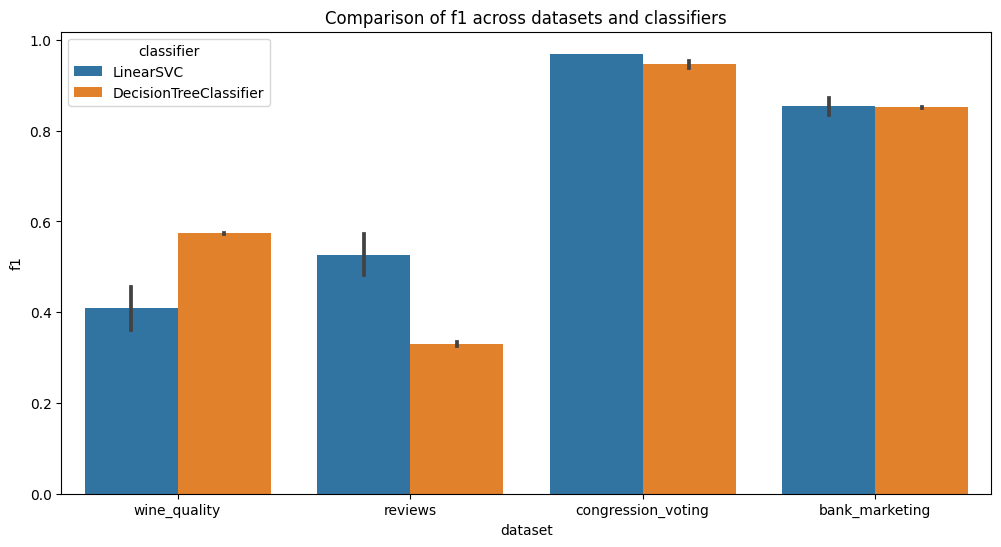

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='classifier', data=results_df)
plt.title('Comparison of f1 across datasets and classifiers')
plt.show()